### Monte Carlo Projet (ENSAE Paris)

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.stats import vonmises
from scipy.optimize import minimize
from statsmodels.graphics.tsaplots import plot_acf

We define the functions to simulate random variables based on the random generator : numpy.random.uniform

In [2]:
def uniform(n=1):
    """ This function simulates a uniform distribution on [0, 1] """
    return np.random.uniform(0, 1, n)


def uniform_1(n=1):
    """ This function simulates a uniform distribution on [-1, 1] """
    return uniform(n=n) * 2 - 1


def uniform_pi(n=1):
    """ This function simulates a uniform distribution on [-pi, pi] """
    return uniform(n=n) * 2 * np.pi - np.pi

def normal(mean=0., std=1., n=1):
    """ This function simulates a normal distribution """

    X, Y = uniform_1(n=n), uniform_1(n=n)
    U = X ** 2 + Y ** 2

    X, U = X[(0 < U) & (U < 1)], U[(0 < U) & (U < 1)]
    while len(X) < n:
        x, y = uniform_1(n=n - len(X)), uniform_1(n=n - len(X))
        u = x ** 2 + y ** 2

        X = np.hstack([X, x[(0 < u) & (u < 1)]])
        U = np.hstack([U, u[(0 < u) & (u < 1)]])
    return mean + std * X * np.sqrt(-2 * np.log(U) / U)


def wrapped_cauchy(mu=0., kappa=1., n=1):
    """ This function simulates a the optimal wrapped cauchy distribution given kappa"""

    tau = 1 + np.sqrt(1 + 4 * kappa ** 2)
    rho = (tau - np.sqrt(2 * tau)) / (2 * kappa)
    s = (1 + rho**2) / (2 * rho)

    U = uniform(n=n)
    V = np.sign(uniform(n=n) - 0.5)
    sim = V * np.arccos((1 + s * np.cos(np.pi * U)) / (s + np.cos(np.pi * U)))
    return (sim + np.pi + mu) % (2 * np.pi) - np.pi


def von_mises_unif(mu=0., kappa=1., n=1):
    """ This function simulates a von Mises distribution using the
    rejection sampler based on a uniform distribution on [-pi, pi]
    as proposal distribution.

    :param float mu: mu
    :param float kappa: kappa
    :param int n: output size

    :return array: sample of a rv following a von mises distribution.
    """

    # Compute a uniform on [-pi, pi]
    sample = uniform_pi(n=n)

    # Compute the value for the rejection test
    val = np.exp(kappa * (np.cos(sample - mu) - 1))

    # Acceptance step
    von_mises = sample[uniform(n) <= val]

    # Keep computing until we have a sample on size n
    while len(von_mises) < n:
        sample = uniform_pi(n - len(von_mises))
        val = np.exp(kappa * (np.cos(sample - mu) - 1))

        von_mises = np.hstack([von_mises, sample[uniform(n - len(von_mises)) <= val]])
    return von_mises


def von_mises_cauchy(mu=0., kappa=1., n=1):
    """
    This function simulates a von Mises distribution using the
    rejection sampler based on a wrapped Cauchy distribution :
    https://www.researchgate.net/publication/246035131_Efficient_Simulation_of_the_von_Mises_Distribution

    :param float mu: mu
    :param float kappa: kappa
    :param int n: output size

    :return array: sample of a rv following a von mises distribution.
    """

    if kappa != 0:
        tau = 1 + np.sqrt(1 + 4 * kappa**2)
        rho = (tau - np.sqrt(2 * tau)) / (2 * kappa)
        r = (1 + rho**2) / (2 * rho)

        # Create the sample
        z = np.cos(np.pi * uniform(n=n))
        f = (1 + r * z) / (r + z)
        c = kappa * (r - f)
        sample = np.sign(uniform_1(n=n)) * np.arccos(f)

        # Acceptance step
        von_mises = sample[np.log(c / uniform(n=n)) + 1 - c >= 0]

        # Keep computing until we have a sample on size n
        while len(von_mises) < n:
            z = np.cos(np.pi * uniform(n=n))
            f = (1 + r * z) / (r + z)
            c = kappa * (r - f)
            sample = np.sign(uniform_1(n=n)) * np.arccos(f)

            von_mises = np.hstack([von_mises, sample[np.log(c / uniform(n=n)) + 1 - c >= 0]])
    else:
        von_mises = uniform_pi(n=n)

    return (von_mises + np.pi + mu) % (2 * np.pi) - np.pi


def von_mises_unif_acceptance(kappa=1., n=100_000):
    """ This function estimates the acceptance rate according to a uniform distribution
    as proposal distribution.

    :param float kappa: kappa
    :param int n: number of simulations

    :return float: estimation of the acceptance rate in percentage
    """

    # Compute a uniform on [-pi, pi]
    sample = uniform_pi(n=n)

    # Compute the value for the rejection test
    val = np.exp(kappa * (np.cos(sample) - 1))

    # Acceptance step
    von_mises = sample[uniform(n) <= val]
    return 100 * von_mises.shape[0] / n


def von_mises_cauchy_acceptance(kappa=1., n=100_000):
    """
    This function estimates the acceptance rate according to a wrapped cauchy distribution
    as proposal distribution.
    https://www.researchgate.net/publication/246035131_Efficient_Simulation_of_the_von_Mises_Distribution

    :param float mu: mu
    :param float kappa: kappa
    :param int n: number of simulations

    :return float: estimation of the acceptance rate in percentage
    """

    if kappa != 0:
        tau = 1 + np.sqrt(1 + 4 * kappa**2)
        rho = (tau - np.sqrt(2 * tau)) / (2 * kappa)
        r = (1 + rho**2) / (2 * rho)

        # Create the sample
        z = np.cos(np.pi * uniform(n=n))
        f = (1 + r * z) / (r + z)
        c = kappa * (r - f)
        sample = np.sign(uniform_1(n=n)) * np.arccos(f)

        # Acceptance step
        von_mises = sample[np.log(c / uniform(n=n)) + 1 - c >= 0]

    else:
        von_mises = uniform_pi(n=n)

    return 100 * von_mises.shape[0] / n


def von_mises_density(x, mu=0., kappa=1.):
    """ Computes the density of a Von Mises distribution with parameters mu and kappa.
    Defined up to a constant multiplier.

    :param float x: point to be evaluated
    :param float mu: mu
    :param float kappa: kappa

    :return float: von Mises density evaluated on x (up to a constant multiplier).
    """
    return np.exp(kappa * np.cos(x - mu)) * (-np.pi <= x <= np.pi)


def simulate(array):
    plt.gcf().clear()
    plt.hist(array, bins=200, density=True, color='grey')
    plt.show()

Plot some simulations

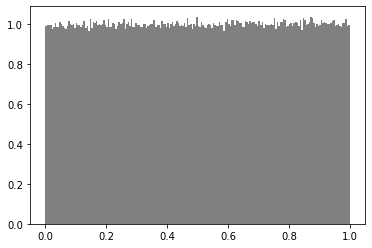

In [3]:
simulate(uniform(n=1_000_000))

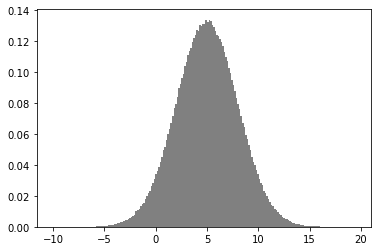

In [4]:
simulate(normal(mean=5., std=3., n=1_000_000))

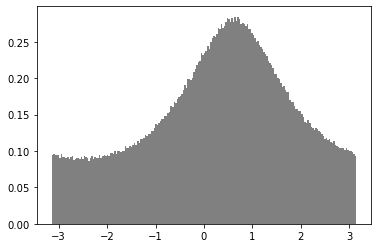

In [5]:
simulate(wrapped_cauchy(mu=np.pi/5, kappa=0.7, n=1_000_000))

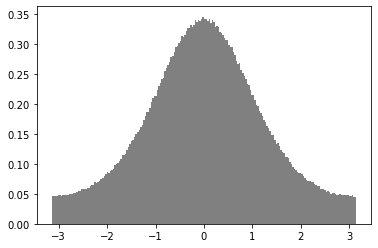

In [6]:
simulate(von_mises_cauchy(mu=0., kappa=1., n=1_000_000))

Define the class based on Rejection Sampling.

In [7]:
class ProjectModel:
    """
    Parent class to all our project models classes, gathering common methods and constructor for every von Mises models.
    """

    def __init__(self, mu=0., kappa=1., x_init=0., proposal='cauchy', proposal_RWHM='gaussian', sig=2.):
        self.mu = mu
        self.kappa = kappa

        # Proposed distribution: 'cauchy' or 'uniform'
        self.proposal = proposal

        if self.__class__.__name__ == 'VonMisesRWHM':
            # The following attributes are built if the object is initialized with the class 'VonMisesRWHM'

            # Initialisation value of the Markov chain;
            self.x_init = x_init

            # Proposed distribution for the random walk: 'gaussian' or 'uniform'
            self.proposal_RWHM = proposal_RWHM

            # Standard deviation (gaussian) or size of the uniform distribution wished for our random walk proposal;
            self.sig = sig

            self.n_accept = 0
            self.acceptance_rate = 0

        # Number of observations the simulation will predict
        self.number_observations = None
        self.results = None

    def estimate_params_MCMC_MLE(self, n=500, m=10_000):
        """ This function estimates the parameters of a von Mises ditribution by MCMC MLE

        :param int n: the number of simulations to estimate the  parameters (mu, kappa)
        :param int m: the number of simulations to estimate the log-likelihood

        :return array (2, 2): numpy array of the parameters and the estimated std
        """

        def log_likelihood(params):
            mu, kappa = params
            res_1 = kappa * np.cos(sample - mu) - np.cos(sample)
            res_2 = np.exp(kappa * np.cos(sample_ - mu) - np.cos(sample_))
            return -res_1.mean() + np.log(res_2.mean())

        params_estimated = np.zeros((n, 2))
        model_ = VonMisesAcceptReject(mu=0., kappa=1.)

        for i in range(n):
            sample = self.simulate(n=m)
            sample_ = model_.simulate(n=m)
            params_estimated[i] = minimize(log_likelihood, np.array([0., 1.])).x

        mu_, kappa_ = params_estimated.mean(axis=0)
        mu_std, kappa_std = params_estimated.std(axis=0) * np.sqrt(n / (n - 1))

        print(
            f"Parameters:\n\u03BC = {mu_:.5f}  [{mu_ - 1.96 * mu_std / n**0.5:.5f}, {mu_ + 1.96 * mu_std / n**0.5:.5f}]"
            f"\n\u03BA = {kappa_:.5f}  [{kappa_ - 1.96 * kappa_std / n**0.5:.5f}, {kappa_ + 1.96 * kappa_std / n**0.5:.5f}]\n"
        )

        return np.array([[mu_, mu_std], [kappa_, kappa_std]])

    def describe_mu(self, save=False):
        """ This function plots the density of a von Mises distribution for different values of mu """

        mu = [-np.pi / 2, 0, np.pi / 2]
        x = np.linspace(-np.pi, np.pi, 300)

        fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
        i = 0

        for val in mu:
            ax[i].plot(x, vonmises.pdf(x, self.kappa, loc=val), 'r-', lw=1)
            ax[i].set_ylim([0., None])
            ax[i].set_xticks([-3.14, 0., 3.14])
            i += 1

        ax[0].title.set_text(f'\u03BC = -\u03C0/2')
        ax[1].title.set_text(f'\u03BC = 0')
        ax[2].title.set_text(f'\u03BC = \u03C0/2')

        ax[0].locator_params(axis="y", nbins=4)
        ax[1].get_yaxis().set_visible(False)
        ax[2].get_yaxis().set_visible(False)

        fig.suptitle(f'von Mises  (\u03BA = {self.kappa})')
        plt.show()
        if save:
            fig.savefig('Graphs/describe_mu.png')

    def describe_kappa(self, save=False):
        """ This function plots the density of a von Mises distribution for different values of kappa """

        kappa = [0, 0.1, 0.5, 1.5, 4, 20]
        x = np.linspace(-np.pi, np.pi, 300)

        fig, ax = plt.subplots(2, 3, figsize=(13, 7))
        i = 1

        ax[0, 0].plot([-np.pi, np.pi], 2 * [1 / (2 * np.pi)], 'r-', lw=1)
        ax[0, 0].set_ylim([0., None])
        ax[0, 0].set_xticks([-3.14, 0., 3.14])
        ax[0, 0].locator_params(axis="y", nbins=4)
        ax[0, 0].title.set_text(f'\u03BA = {0}')

        for val in kappa:
            if val != 0:
                ax[i // 3, i % 3].plot(x, vonmises.pdf(x, val, loc=0.), 'r-', lw=1)
                ax[i // 3, i % 3].set_ylim([0., None])
                ax[i // 3, i % 3].set_xticks([-3.14, 0., 3.14])
                ax[i // 3, i % 3].locator_params(axis="y", nbins=4)
                ax[i // 3, i % 3].title.set_text(f'\u03BA = {val}')
                i += 1

        fig.suptitle('von Mises (\u03BC = 0)')
        fig.tight_layout(pad=1.0)
        plt.show()
        if save:
            fig.savefig('Graphs/describe_kappa.png')

    def simulate(self, n=1, verbose=False):
        raise NotImplementedError("The method should be defined in each child class.")
        pass

    def hist(self):
        """
        Generates and plots the graph of the observations made under the simulation of our model.
        """

        if self.results is None:
            logging.warning("No simulation has been launched yet: computing ...")
            self.simulate(n=1)

        plt.gcf().clear()
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_axes([0.065, 0.1, 0.75, 0.8])

        ax.hist(self.results, bins=200, density=True, color='grey')
        x = np.linspace(-np.pi, np.pi, 100)
        ax.plot(x, vonmises.pdf(x, self.kappa, loc=self.mu), 'r-', lw=1, label='theoretical')

        ax.text(3.85, 0.15,
                f'proposal: {self.proposal}\n\n'
                f'\u03BC:            {self.mu:.3f}\n'
                f'\u03BA:            {self.kappa:.3f}\n'
                f'n:       {self.number_observations:.1e}',
                style='italic',
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

        ax.set_title(f'von Mises simulation : {self.__class__.__name__}.')
        plt.legend()
        plt.show()


class VonMisesAcceptReject(ProjectModel):
    """
    Accept-Reject simulation for von Mises distribution.
    """

    def simulate(self, n=1, verbose=False):
        """
        Generates n simulations under our von Mises Accept-Reject simulation.

        :param int n: number of simulations
        :param bool verbose: display parameter (only here to make sure we have the same signature
        :return array: list of simulations
        """

        self.number_observations = n
        if self.proposal == 'cauchy':
            self.results = von_mises_cauchy(mu=self.mu, kappa=self.kappa, n=n)
        elif self.proposal == 'uniform':
            self.results = von_mises_unif(mu=self.mu, kappa=self.kappa, n=n)
        else:
            raise NotImplementedError('Wrong proposal.')
        return self.results

    def describe_simulation(self, save=False):
        """ This function plots the simulation of a von Mises distribution for different values of n """

        n = [10_000, 100_000, 1_000_000]
        x = np.linspace(-np.pi, np.pi, 300)

        fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
        i = 0

        for val in n:
            self.simulate(n=val)
            ax[i].hist(self.results, bins=200, density=True, color='grey')
            ax[i].plot(x, vonmises.pdf(x, self.kappa, loc=self.mu), 'r-', lw=1, label='theoretical')

            if self.proposal == 'uniform':
                ax[i].plot([-np.pi, np.pi], 2 * [vonmises.pdf(x, self.kappa, loc=self.mu).max()], 'b-', lw=1,
                           label='proposal')

            elif self.proposal == 'cauchy':
                y, x = np.histogram(wrapped_cauchy(mu=self.mu, kappa=self.kappa, n=10_000_000),
                                    bins=np.linspace(-np.pi, np.pi, 1_000), density=True)
                y_, _ = np.histogram(von_mises_cauchy(mu=self.mu, kappa=self.kappa, n=10_000_000),
                                     bins=np.linspace(-np.pi, np.pi, 1_000), density=True)
                ax[i].plot((x[:-1] + x[1:]) / 2, (y_ / y).max() * gaussian_filter1d(y, sigma=10), 'b-', lw=1,
                           label='proposal')

            ax[i].set_ylim([0., None])
            ax[i].set_xticks([-3.14, 0., 3.14])
            ax[i].title.set_text(f'n = {val:.1e}')
            i += 1

        ax[0].locator_params(axis="y", nbins=4)
        ax[1].get_yaxis().set_visible(False)
        ax[2].get_yaxis().set_visible(False)

        fig.suptitle(f'von Mises  (\u03BC = {self.mu:.3f},  \u03BA = {self.kappa:.3f},  proposal = {self.proposal})')
        plt.legend(prop={'size': 8})
        plt.show()

        if save:
            fig.savefig('Graphs/describe_simulation_' + self.proposal + '.png')

    def acceptance_rate_simulation(self, save=False):
        """ This function plots the acceptance rate of the rejection test for different values of kappa
        for each proposal distribution """

        n = 1_000_000
        kappa = np.linspace(0, 50, 300)

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(kappa, [von_mises_cauchy_acceptance(kappa=val, n=n) for val in kappa], 'b-', lw=1,
                label='wrapped cauchy')
        ax.plot(kappa, [von_mises_unif_acceptance(kappa=val, n=n) for val in kappa], 'r-', lw=1, label='uniform')
        ax.set_yticks([0, 25, 50, 75, 100])

        ax.grid(True, linewidth=0.5, color='grey', linestyle='-')
        ax.set_xlabel("\u03BA")
        ax.set_ylabel("Acceptance rate")
        ax.set_title("Acceptance rate")
        plt.legend()
        plt.show()

        if save:
            fig.savefig('Graphs/acceptance_rate.png')


In [8]:
mu = np.pi/5
kappa = 0.7
n = 1_000_000
proposal = 'cauchy'

model = VonMisesAcceptReject(mu=mu, kappa=kappa, proposal=proposal)

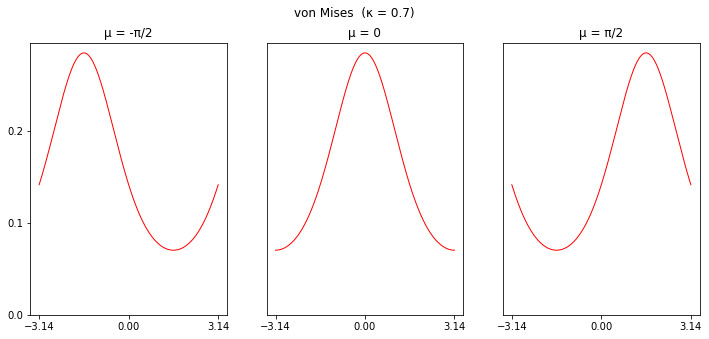

In [9]:
model.describe_mu()  # plots the density for different values of mu

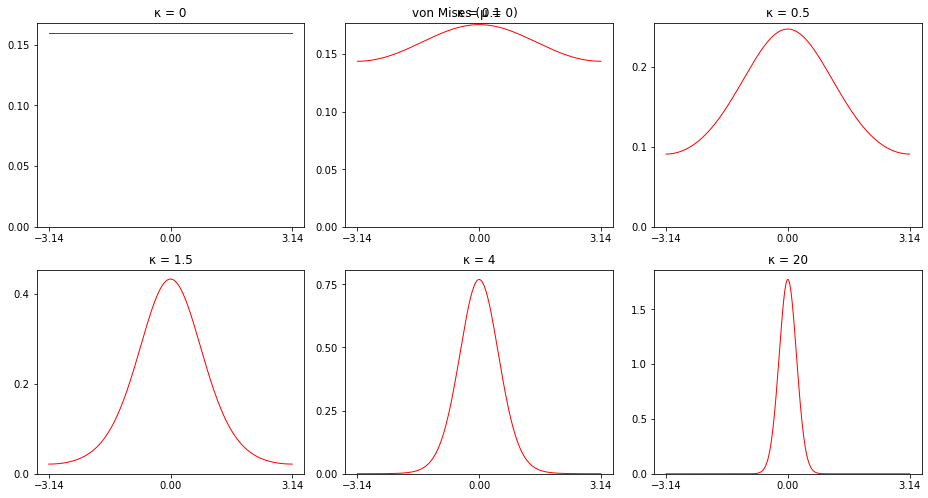

In [10]:
model.describe_kappa()  # plots the density for different values of kappa

<Figure size 432x288 with 0 Axes>

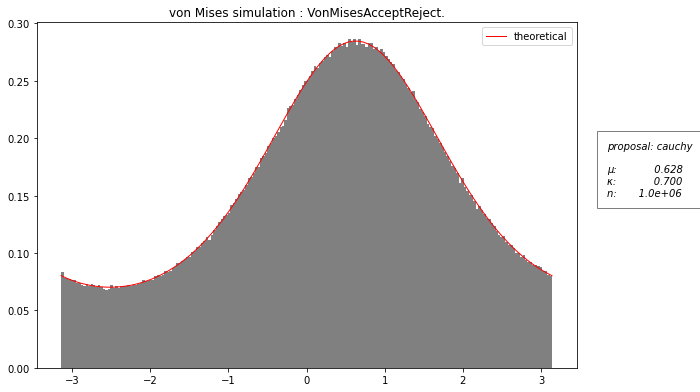

In [11]:
model.simulate(n=n)  # generates n observations under the Accept-Reject simulation
model.hist()  # generates the histogram of the above observations

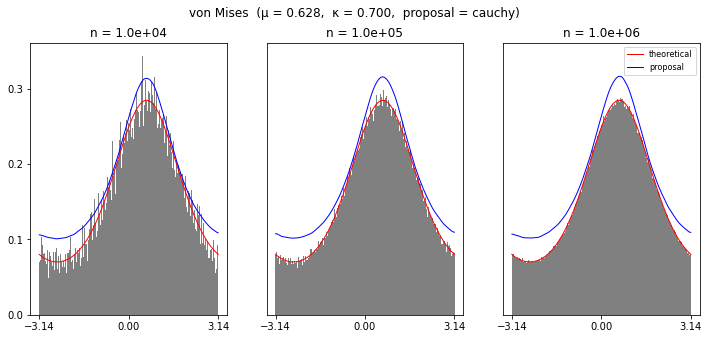

In [12]:
model.describe_simulation()  # plots the simulation for different values of n

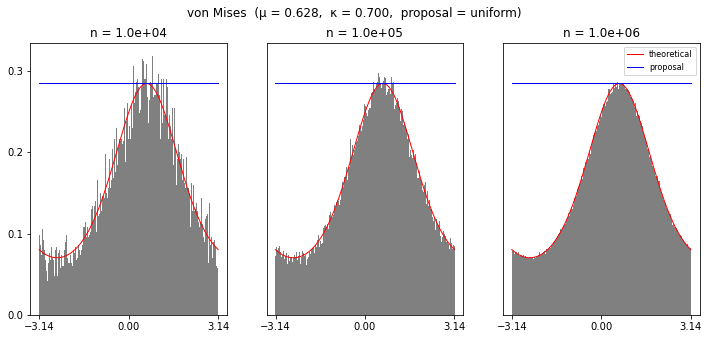

In [13]:
VonMisesAcceptReject(mu=mu, kappa=kappa, proposal='uniform').describe_simulation()

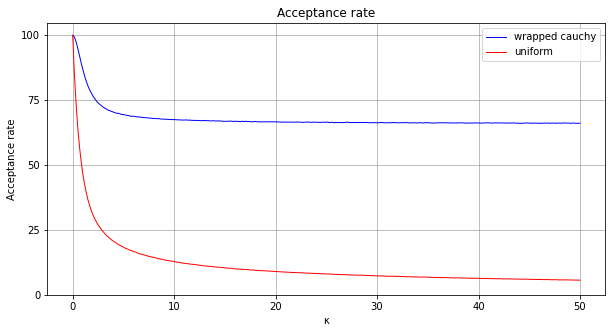

In [14]:
model.acceptance_rate_simulation()  # plots the acceptance rate against kappa

In [15]:
model.estimate_params_MCMC_MLE()  # estimates the parameters of the model by MCMC MLE

Parameters:
μ = 0.62937  [0.62732, 0.63142]
κ = 0.70103  [0.69961, 0.70245]



array([[0.62936972, 0.0233754 ],
       [0.70103162, 0.01622869]])

Define the class based on Metropolis-Hastings Algorithm

In [16]:
class VonMisesRWHM(ProjectModel):
    """
    Random Walk Hastings-Metropolis (RWHM) simulation for von Mises distribution.
    """

    @staticmethod
    def proposal_step(proposal_RWHM='gaussian', sig=2.):
        """
        Computes the step of the random walk.

        :param str proposal_RWHM: proposed function
        :param float sig: standard deviation (gaussian) or size of the uniform distribution wished for our random walk
        proposal
        :return float: the random walk step
        """
        if proposal_RWHM == 'gaussian':
            return sig * normal(n=1)
        elif proposal_RWHM == 'uniform':
            return sig * uniform_1(n=1)
        else:
            raise NotImplementedError('Wrong proposal')

    def iter(self, x):
        """
        Does an iteration of the RWHM simulation.

        :param float x: initial value
        :return float: new value of the Markov chain
        """

        proposal_step = self.proposal_step(self.proposal_RWHM, self.sig)
        y = x + proposal_step
        r = von_mises_density(y, mu=self.mu, kappa=self.kappa) / von_mises_density(x, mu=self.mu, kappa=self.kappa)
        u = np.random.rand()

        if u < r:
            self.n_accept += 1
            return y
        else:
            return x

    def simulate(self, n=100_000, verbose=False):
        """
        Generates n simulations under our von Mises Random Walk Hastings-Metropolis simulation.

        :param int n: number of simulations
        :param bool verbose: display parameter
        :return list: list of simulations
        """

        self.number_observations = n
        self.n_accept = 0

        x = np.empty(n)
        x[0] = self.x_init
        for i in range(1, n):
            x[i] = self.iter(x[i - 1])

        self.acceptance_rate = self.n_accept / n
        if verbose:
            print(f'Acceptance rate: {self.acceptance_rate:.1%}\n')  # should be calibrated between 25% and 40%
        # According to G. O. Roberts, A. Gelman and W. R. Gilks  https://www.jstor.org/stable/2245134?seq=1
        # the optimal rate should be 23.4%

        self.results = x
        return self.results

    def describe_simulation(self, save=False):
        """ This function plots the simulation of a von Mises distribution for different values of n """

        n = [10_000, 100_000, 1_000_000]
        x = np.linspace(-np.pi, np.pi, 300)

        fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
        i = 0

        for val in n:
            self.simulate(n=val)
            ax[i].hist(self.results, bins=200, density=True, color='grey')
            ax[i].plot(x, vonmises.pdf(x, self.kappa, loc=self.mu), 'r-', lw=1, label='theoretical')

            ax[i].set_ylim([0., None])
            ax[i].set_xticks([-3.14, 0., 3.14])
            ax[i].title.set_text(f'n = {val:.1e}')
            i += 1

        self.simulate(n=10_000)  # Reset the simulation

        ax[0].locator_params(axis="y", nbins=4)
        ax[1].get_yaxis().set_visible(False)
        ax[2].get_yaxis().set_visible(False)

        fig.suptitle(
            f'von Mises  (\u03BC = {self.mu:.3f},  \u03BA = {self.kappa:.3f},  proposal_RWHM = {self.proposal_RWHM})')
        plt.legend(prop={'size': 8})
        plt.show()

        if save:
            fig.savefig('Graphs/describe_simulation_RWHM_' + self.proposal_RWHM + '.png')

    def fit(self, len_batch=1000, num_iter=1000, min_rate=0.25, max_rate=0.3):
        """
        Chooses an optimal value for sigma, the standard deviation of our random walk. Keep in mind when choosing
        parameters that the number of simulation that will be computed is len_batch * num_iter.

        :param int len_batch: number of simulations for each Von Mises estimation.
        :param int num_iter: number of sigma that we want to try.
        :param float min_rate: lower bound for the acceptance rate.
        :param float max_rate: upper bound for the acceptance rate.
        :return float sig: the advised value for sigma.
        """

        old_sig = self.sig  # Stocks the value of sigma initially entered by user.
        step = 10 / num_iter
        sigma_proposals = [step * i for i in range(1, num_iter)]

        for i in range(num_iter):
            sig = sigma_proposals[i]
            self.sig = sig
            self.simulate(len_batch, verbose=False)

            if min_rate < self.acceptance_rate < max_rate:
                print(f'Recommended value for sigma : {sig}\nAcceptance rate around {self.acceptance_rate:.1%}')
                print(f'{i} iterations to find a fitting value\n')
                return sig

        self.sig = old_sig  # In order not to modify the sigma value wished by the user.
        print("Couldn't find a sigma that satisfies the acceptance rate criteria\n")
        return None

    def graph_chain(self, n_points=100):
        """
        Draw the the Markov chain. A sanity-check for this MCMC simulation is to have the graph looks 'random' : i.e. a
        randoms series where no particular pattern appears.

        :param int n_points: number of points to display
        :return None: returns the graph of the chain.
        """

        plt.plot(self.results[:n_points])
        plt.show()

    def graph_autocorrelation(self):
        """
        Draw the autocorrelations of the Markov chain. A sanity-check for this MCMC simulation is to have the
        autocorrelations plummet rapidly.

        :return None: returns the graph of the autocorrelations.
        """

        plot_acf(self.results)
        plt.show()


In [17]:
x_init = 0
proposal_RWHM = 'gaussian'  # 'gaussian' or 'uniform'
sig = 2.5
n = 100_000

model_RWHM = VonMisesRWHM(mu=mu, kappa=kappa, proposal=proposal, x_init=x_init, proposal_RWHM=proposal_RWHM, sig=sig)

In [18]:
model_RWHM.fit()  # find sig in order to have a proper acceptance rate 

Recommended value for sigma : 5.34
Acceptance rate around 28.9%
533 iterations to find a fitting value



5.34

Acceptance rate: 31.6%



<Figure size 432x288 with 0 Axes>

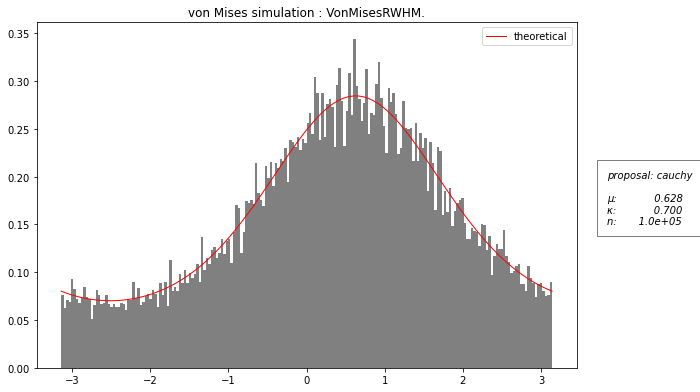

In [19]:
model_RWHM.simulate(n=n, verbose=True)  # generates n observations under the Random Walk Hastings-Metropolis simulation
model_RWHM.hist()  # generates the histogram of the above observations

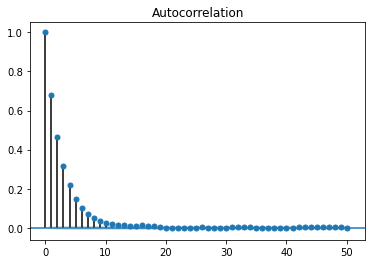

In [20]:
model_RWHM.graph_autocorrelation()

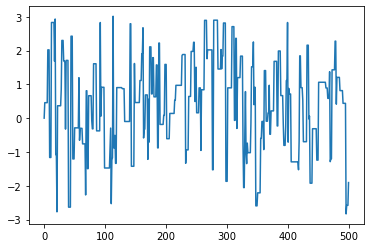

In [21]:
model_RWHM.graph_chain(n_points=500)

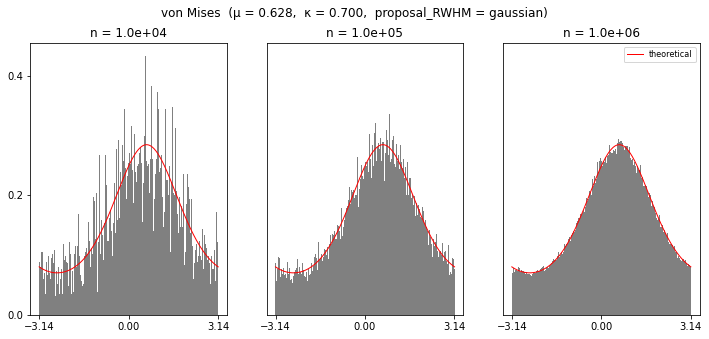

In [22]:
model_RWHM.describe_simulation()